In [92]:
import mdtraj as md
import torch
import numpy as np

In [71]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

ctx = torch.zeros([], device=device, dtype=dtype)

In [72]:
from bgmol.datasets import Ala2TSF300

target_energy = Ala2TSF300().get_energy_model(n_workers=1)

Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


In [73]:
import mdtraj
constrained_samples_traj = mdtraj.load('constrained_samples.dcd', top='ala2_fromURL.pdb')
my_traj = mdtraj.load('obcimplicit.dcd', top='ala2_fromURL.pdb',stride=286)
TSF_samples_traj = mdtraj.load('TSF_stride35_samplestraj.dcd', top='ala2_fromURL.pdb',stride=10)
my_samples_traj = mdtraj.load('obcstride10Samplestraj.dcd',top='ala2_fromURL.pdb',stride = 10)
print(constrained_samples_traj,my_traj,my_samples_traj,TSF_samples_traj)

<mdtraj.Trajectory with 1000 frames, 22 atoms, 3 residues, without unitcells> <mdtraj.Trajectory with 1002 frames, 22 atoms, 3 residues, and unitcells> <mdtraj.Trajectory with 1000 frames, 22 atoms, 3 residues, without unitcells> <mdtraj.Trajectory with 1000 frames, 22 atoms, 3 residues, without unitcells>


In [74]:
def get_energies(trajectory, target_energy):
    coordinates = trajectory.xyz
    data = torch.tensor(coordinates.reshape(-1,66)).to(ctx)
    return target_energy.energy(data).cpu().detach().numpy()

In [75]:
import matplotlib.pyplot as plt

In [115]:
def plot_energy(ax, constr_data, my_samples_data, TSF_samples_data, my_data):
    
    my_samples_energies = get_energies(my_samples_data, target_energy)
    #my_energies = get_energies(my_data, target_energy)
    constr_samples_energies = get_energies(constr_data, target_energy)
    TSF_samples_energies = get_energies(TSF_samples_data, target_energy)

    cut = max(np.percentile(TSF_samples_energies, 80), 
        #np.percentile(my_energies,80),
        np.percentile(my_samples_energies,80),
        np.percentile(constr_samples_energies,80),
        20
        )
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    #ax2 = plt.twinx(ax)
    #ax.get_yaxis().set_visible(False)
    
    ax.hist(my_samples_energies, range=(-50 ,cut), bins=40, density=False, label="BG samples trained on my MD", alpha = 1)
    ax.hist(constr_samples_energies, range=(-50 ,cut), bins=40, density=False, label="BG samples trained on my MD with constrained bonds", alpha = 0.6)
    #ax.hist(my_energies, range=(-50 ,cut), bins=40, density=False, label="my MD",alpha=0.6)
    ax.hist(TSF_samples_energies, range=(-50 ,cut), bins=40, density=False, label="BG samples trained on TSF MD", alpha = 0.6)

    ax.set_ylim([0,200])
    ax.set_ylabel(f"Count   [#Samples / 1000]")
    ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')

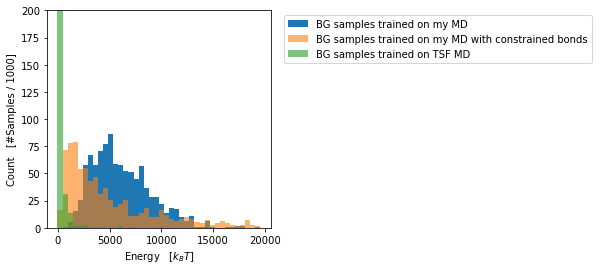

In [119]:
fig, ax = plt.subplots(figsize=(4,4))

plot_energy(ax, constrained_samples_traj,my_samples_traj,TSF_samples_traj,my_traj)
plt.savefig('constrainedbonds_samples.png',bbox_inches='tight')